In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)
staff_number = 6

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [4]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))

## Tabela prompt_dates

In [5]:
# shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
# today = datetime.datetime(2023,6,25)

In [6]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [7]:
generated_dates = gen_dates(shop_open_date, today)

In [8]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')

## Ruch - dni

In [9]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(A+B*i+dd)

In [10]:
prompt_dates['volume_base'] = volume_base

In [11]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [12]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,0.4*v_base+szum))

prompt_dates['volume_rental'] = volume_rental

In [13]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7.00,7.00,3.800
1,2021-06-02,Środa,6.01,6.01,1.404
2,2021-06-04,Piątek,11.02,12.02,4.408
3,2021-06-05,Sobota,11.03,11.03,3.412
4,2021-06-07,Poniedziałek,8.04,8.04,0.216


## Tabela procentowa z godzinami

In [14]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [15]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

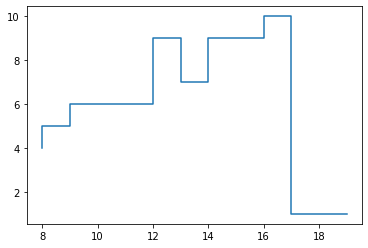

In [16]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [17]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [18]:
sum(hours_prompt['Natężenie'])

1.0

## Gry

In [19]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [20]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,Dobry rok,planszowa,strategiczna,"Gra ""Dobry Rok"" sprawdzi się u dzieci w wieku ...",NIE,160.97,NaN,NaN
2,Ryzyk Fizyk,planszowa,towarzyska,Najczęściej nagradzana gra imprezowa! Ile waży...,TAK,104.73,10.0,14
3,Scythe,planszowa,strategiczna,Scythe to gra idealnie łącząca ze sobą mechani...,TAK,289.00,NaN,5
4,Munchkin,karciana,towarzyska,"Munchkin to niekolekcjonerska gra karciana, kt...",TAK,44.90,11.0,5


In [21]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [22]:
sum(prompt_games['wagi'])

1.0000000000000002

_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [23]:
id_generator = lambda n: [*range(1, n+1)]


city_generator = lambda n: random.choices(prompt_cities['miasto'], weights=prompt_cities['prob'], k=n)


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.')
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False)
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [81]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'staff_id': [*id_generator(n)],
        'city': [*city_generator(n)],
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [82]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
0,1,ZOFIA,ADAM,886663734,ZOFIA.ADAM@go2.pl,Złotoryja,3623.63,False,F,2021-06-01,NaN,2021-06-01
1,2,DOMINIK,KASZA,603029618,DOMINIK.KASZA@yahoo.com,Strzegom,3707.67,False,M,2021-06-01,NaN,2021-06-01
2,3,ELIZA,MICHALAK,450819521,ELIZA.MICHALAK@onet.pl,Jawor,3747.36,True,F,2021-06-01,NaN,2021-06-01
3,4,KAMIL,BARTNIKOWSKI,514833498,KAMIL.BARTNIKOWSKI@home.pl,Wrocław,3583.30,False,M,2021-06-01,NaN,2021-06-01
4,5,RYSZARD,BRODA,452473619,RYSZARD.BRODA@o2.pl,Legnica,NaN,False,M,2021-06-01,2022-09-07,2022-09-07
5,6,ŁUCJA,KLIŚ,604854754,ŁUCJA.KLIŚ@home.pl,Wrocław,3609.96,False,F,2022-10-07,NaN,2022-10-07


## Godziny pracy

## Związki

In [26]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [27]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_time_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = [*range(1, n+1)]
    df['partner_id'] = [*range(1, n+1)]
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [28]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
4,1,1,M,1,6,2021-07-26 02:53:30
8,2,4,F,2,2,2021-10-30 15:45:11
0,3,4,F,3,4,2022-01-21 11:22:19
7,4,1,M,4,6,2022-04-20 12:52:01
2,5,4,F,5,9,2022-05-08 15:04:04
6,6,6,M,6,4,2023-02-09 21:50:34
1,7,6,M,7,5,2023-03-08 18:42:58
3,8,6,M,8,6,2023-03-30 12:29:11
5,9,6,M,9,6,2023-05-15 04:29:25


## Partnerzy

In [29]:
def partners_df_generator(relationships_df):
    n = relationships_df.shape[0]
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [30]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
4,1,KRZYSZTOF,M,2021-07-26 02:53:30
8,2,KRZYSZTOF,M,2021-10-30 15:45:11
0,3,JACEK,M,2022-01-21 11:22:19
7,4,ANNA,F,2022-04-20 12:52:01
2,5,ŁUKASZ,M,2022-05-08 15:04:04
6,6,ZOFIA,F,2023-02-09 21:50:34
1,7,MAŁGORZATA,F,2023-03-08 18:42:58
3,8,ALINA,F,2023-03-30 12:29:11
5,9,ANNA,F,2023-05-15 04:29:25


## Klienci - część A

In [31]:
customers = pd.DataFrame({'customer_id': [i for i in range(1,1501)]})

## Koszty utrzymania

In [32]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7.00,7.00,3.800
1,2021-06-02,Środa,6.01,6.01,1.404
2,2021-06-04,Piątek,11.02,12.02,4.408
3,2021-06-05,Sobota,11.03,11.03,3.412
4,2021-06-07,Poniedziałek,8.04,8.04,0.216


In [33]:
maintenance_expenses = pd.DataFrame({
    'date': [],
    'title': [],
    'amount': [],
    'type': [],
    'updated_at': []
})

maintenance_expenses

,date,title,amount,type,updated_at


In [190]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'czynsz ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'czynsz')[0]
    })
    return df    

In [191]:
rent_generator()

,date,title,amount,type
3,2021-06-05,czynsz czerwiec,3250,czynsz
28,2021-07-05,czynsz lipiec,3250,czynsz
55,2021-08-05,czynsz sierpień,3250,czynsz
107,2021-10-05,czynsz październik,3250,czynsz
133,2021-11-05,czynsz listopad,3250,czynsz
182,2022-01-05,czynsz styczeń,3250,czynsz
208,2022-02-05,czynsz luty,3250,czynsz
232,2022-03-05,czynsz marzec,3250,czynsz
258,2022-04-05,czynsz kwiecień,3250,czynsz
282,2022-05-05,czynsz maj,3250,czynsz


In [192]:
pd.concat([maintenance_expenses, rent_generator()])

,date,title,amount,type,updated_at
3,2021-06-05,czynsz czerwiec,3250.0,czynsz,NaN
28,2021-07-05,czynsz lipiec,3250.0,czynsz,NaN
55,2021-08-05,czynsz sierpień,3250.0,czynsz,NaN
107,2021-10-05,czynsz październik,3250.0,czynsz,NaN
133,2021-11-05,czynsz listopad,3250.0,czynsz,NaN
182,2022-01-05,czynsz styczeń,3250.0,czynsz,NaN
208,2022-02-05,czynsz luty,3250.0,czynsz,NaN
232,2022-03-05,czynsz marzec,3250.0,czynsz,NaN
258,2022-04-05,czynsz kwiecień,3250.0,czynsz,NaN
282,2022-05-05,czynsz maj,3250.0,czynsz,NaN


In [193]:
def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'energia elektryczna ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df

In [194]:
energy_generator()

,date,title,amount,type
3,2021-06-05,energia elektryczna czerwiec,162.54,media
28,2021-07-05,energia elektryczna lipiec,152.27,media
55,2021-08-05,energia elektryczna sierpień,148.14,media
107,2021-10-05,energia elektryczna październik,144.79,media
133,2021-11-05,energia elektryczna listopad,153.00,media
182,2022-01-05,energia elektryczna styczeń,149.88,media
208,2022-02-05,energia elektryczna luty,147.38,media
232,2022-03-05,energia elektryczna marzec,155.47,media
258,2022-04-05,energia elektryczna kwiecień,142.28,media
282,2022-05-05,energia elektryczna maj,157.27,media


In [195]:
pd.concat([maintenance_expenses, rent_generator(), energy_generator()])

,date,title,amount,type,updated_at
3,2021-06-05,czynsz czerwiec,3250.00,czynsz,NaN
28,2021-07-05,czynsz lipiec,3250.00,czynsz,NaN
55,2021-08-05,czynsz sierpień,3250.00,czynsz,NaN
107,2021-10-05,czynsz październik,3250.00,czynsz,NaN
133,2021-11-05,czynsz listopad,3250.00,czynsz,NaN
182,2022-01-05,czynsz styczeń,3250.00,czynsz,NaN
208,2022-02-05,czynsz luty,3250.00,czynsz,NaN
232,2022-03-05,czynsz marzec,3250.00,czynsz,NaN
258,2022-04-05,czynsz kwiecień,3250.00,czynsz,NaN
282,2022-05-05,czynsz maj,3250.00,czynsz,NaN


In [226]:
def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'woda ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df

In [227]:
water_generator()

,date,title,amount,type
3,2021-06-05,woda czerwiec,51.89,media
28,2021-07-05,woda lipiec,46.78,media
55,2021-08-05,woda sierpień,51.19,media
107,2021-10-05,woda październik,53.31,media
133,2021-11-05,woda listopad,48.86,media
182,2022-01-05,woda styczeń,49.22,media
208,2022-02-05,woda luty,49.31,media
232,2022-03-05,woda marzec,48.02,media
258,2022-04-05,woda kwiecień,52.90,media
282,2022-05-05,woda maj,50.22,media


In [228]:
def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL')
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df

In [229]:
heat_generator()

,date,title,amount,type
133,2021-11-05,Listopad,100.83,media
182,2022-01-05,Styczeń,101.71,media
208,2022-02-05,Luty,94.35,media
232,2022-03-05,Marzec,105.24,media
437,2022-11-05,Listopad,97.78,media
461,2022-12-05,Grudzień,102.85,media
487,2023-01-05,Styczeń,102.47,media


## Tytuły wydatków

## Typy wydatków

## Wydatki i tytuły jeszcze raz

## Turnieje

## Udziały

## Magazyn

## Ceny gier

## Sprzedaże

## Rentale

## Gry

## Katrgorie gier i typy gier

## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele